I am looking at the las vegas super contest -- how do the experts compare to randomness

data from: https://www.westgateresorts.com/hotels/nevada/las-vegas/westgate-las-vegas-resort-casino/casino/2025-supercontest-standings/


NOTE: here be dragons, it turns out there's a source where I can get csv data directly for 10+ years of the supercontest. see the super_contest.ipynb notebook. there's also some potential stats mistakes

In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

latest through week 15. some of later text may be wrong as far as pcts

In [2]:
with open("../content/data/supercontest-15.txt", "r") as f:
    data = f.read()

In [3]:
lines = data.split("\n")

In [4]:
matcher = r"^([\dT]+)\W(.+?)\W([\d]+)-([\d]+)-([\d]+)-([\d]+)\W([\d\.]+)$"
# God bless regex101 and its developers

In [5]:
re.split(matcher, lines[100])

['', '85T', 'PHATCAT-1', '41', '34', '0', '0', '41.00', '']

In [6]:
clean = []

for line in lines:
    clean.append(re.split(matcher, line)[1:-1])

In [7]:
should_be_numeric = ["wins", "losses", "ties", "cancels", "points"]

cols = ["rank", "team_name"] + should_be_numeric

stupor_contest = pd.DataFrame(clean, columns=cols)
stupor_contest[should_be_numeric] = stupor_contest[should_be_numeric].apply(pd.to_numeric)
stupor_contest['units'] = stupor_contest.wins - (1.1 * stupor_contest.losses)
stupor_contest['win_pct'] = stupor_contest.wins / (stupor_contest.wins + stupor_contest.losses)
stupor_contest['n_games'] = stupor_contest.wins + stupor_contest.losses # ignoring ties, which I'll not be simulating

stupor_contest = stupor_contest.dropna()

In [37]:
stupor_contest.loc[stupor_contest.units.idxmin()]

rank                        747
team_name    THISSHOULDBEEASY-1
wins                       24.0
losses                     49.0
ties                        2.0
cancels                     0.0
points                     25.0
units                     -29.9
win_pct                0.328767
n_games                    73.0
Name: 747, dtype: object

In [40]:
sum(stupor_contest.n_games)

54924.0

In [43]:
sum(stupor_contest.win_pct < .5) / len(stupor_contest)

0.5912117177097204

let's see how likely it is due to chance that only 41% would have a winning record

In [10]:
sum(stupor_contest.win_pct < .5)

444

In [11]:
len(stupor_contest)

751

In [12]:
1/np.sqrt(3000)

np.float64(0.018257418583505537)

In [13]:
import scipy.stats
#bt = scipy.stats.binomtest(k=sum(stupor_contest.win_pct >= .5), n=len(stupor_contest), p=.5)
# we want theoretical here
bt = scipy.stats.binomtest(k = int(round(.5 * len(stupor_contest))), n=len(stupor_contest))
bt.proportion_ci()

ConfidenceInterval(low=0.4642974914476701, high=0.537028819378401)

we would expect between 46-54% to have a winning record

In [14]:
1/scipy.stats.binomtest(k=sum(stupor_contest.win_pct >= .5), n=len(stupor_contest), p=.5).pvalue

np.float64(1539592.8912637292)

<Axes: >

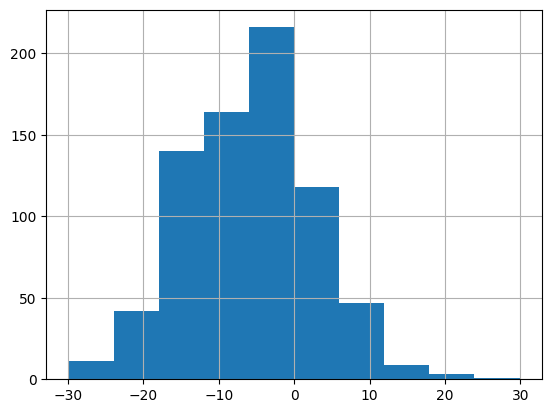

In [15]:
stupor_contest.units.hist()

looks like there are a few teams that ragequit. number of games isn't counting ties because I don't want to simulate them.

In [16]:
stupor_contest.n_games.value_counts()

n_games
74.0    302
73.0    233
75.0    118
72.0     53
69.0     12
68.0     10
71.0      3
63.0      3
64.0      3
70.0      2
67.0      2
65.0      2
45.0      2
59.0      1
60.0      1
53.0      1
55.0      1
48.0      1
30.0      1
Name: count, dtype: int64

over 75% of the super contest teams are losing money against the spread

In [17]:
len(stupor_contest[stupor_contest.units < 0]) / len(stupor_contest)

0.762982689747004

only 39% of them have a winning percentage over .5. Can that possibly be right?

edit: yes, yes it can, I doublechecked things and they're really that ass

In [18]:
len(stupor_contest[stupor_contest.win_pct > .5]) / len(stupor_contest)

0.3595206391478029

In [19]:
stupor_contest.win_pct.describe()

count    751.000000
mean       0.485863
std        0.055009
min        0.328767
25%        0.445946
50%        0.486486
75%        0.520548
max        0.716216
Name: win_pct, dtype: float64

In [46]:
len(stupor_contest[stupor_contest.win_pct < .45]) / len(stupor_contest)

0.26498002663115844

In [ ]:
len(stupor_contest[stupor_contest.win_pct >= .524])

178

In [22]:
stupor_contest.wins.sum() / (stupor_contest.wins.sum() + stupor_contest.losses.sum())


np.float64(0.485980627776564)

<Axes: >

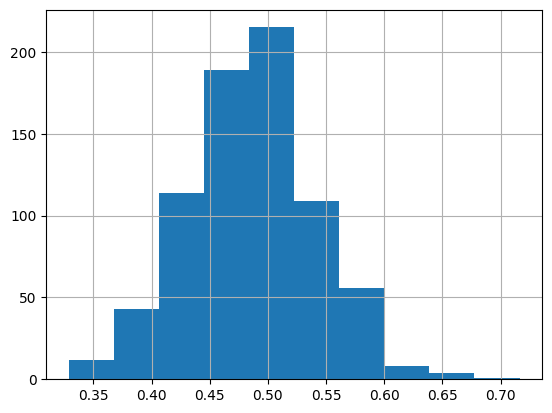

In [23]:
stupor_contest.win_pct.hist()

In [24]:
rng = np.random.default_rng(8088)

In [25]:
n_simulations = 1000

_fake_results = []
for sim in range(n_simulations):
    for idx, row in stupor_contest.iterrows():
        
        num_wins = rng.binomial(row.n_games, .5)
        _fake_results.append(num_wins / row.n_games)

fake = pd.Series(_fake_results)

48% of simulated entries have a winning record, about what we'd expect. a lot of teams we are simulating have an even number of games played so there will be a lot of fake teams with exactly .500 record

In [26]:
sum(fake > .500) / len(fake)

0.4765699067909454

In [27]:
sum(fake == .5)

34380

In [28]:
some_bins = [.30, .35, .40, .45, .50, .55, .60, .65]

some_bins = [30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60, 62.5, 65, 70]

LOL, they are so much worse than a coin flip

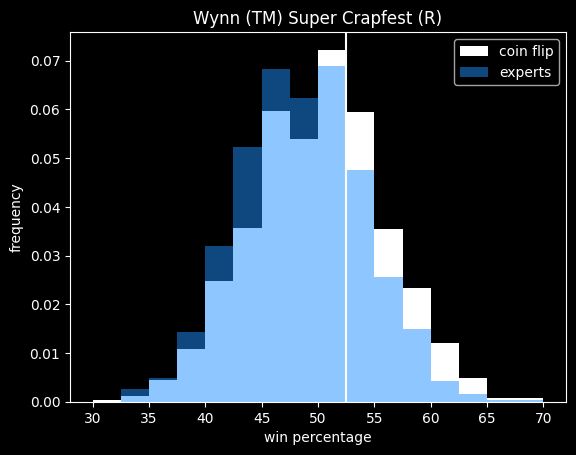

In [29]:
plt.style.use('dark_background')

plt.title("Wynn (TM) Super Crapfest (R)")
plt.hist(100 * fake, bins=some_bins, density=True, color='white', label="coin flip")
plt.hist(100 * stupor_contest.win_pct, bins=some_bins, density=True, color='dodgerblue', alpha=.5, label="experts")
#plt.axvline(50, color="white")
plt.axvline(52.5, color="white")
plt.xlabel("win percentage")
plt.ylabel("frequency")

plt.legend()

TODO: do net diff, can use np.histogram I think

In [30]:
np.histogram(100 * fake, bins=some_bins, density=True)

(array([0.0004546 , 0.00126788, 0.00448313, 0.01079906, 0.02479632,
        0.03567425, 0.05960026, 0.05397503, 0.07223425, 0.05942333,
        0.03549624, 0.02332539, 0.01195608, 0.00478957, 0.0008623 ]),
 array([30. , 32.5, 35. , 37.5, 40. , 42.5, 45. , 47.5, 50. , 52.5, 55. ,
        57.5, 60. , 62.5, 65. , 70. ]))

In [31]:
fake_hist = np.histogram(100 * fake, bins=some_bins, density=True)


real_minus_fake = np.histogram(100 * stupor_contest.win_pct, bins=some_bins, density=True, )[0] - fake_hist[0]

Text(0.5, 1.0, 'excess losing, real gamblers')

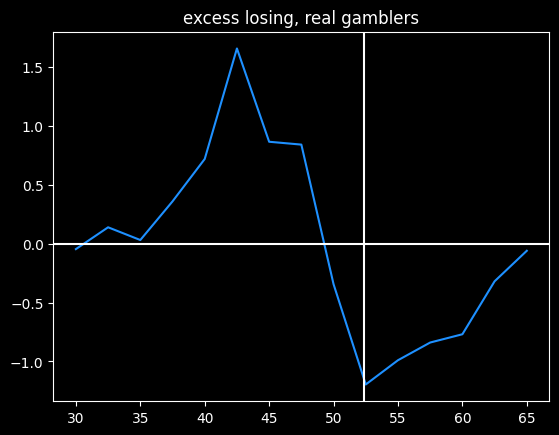

In [32]:
plt.plot(fake_hist[1][:-1], real_minus_fake * 100, color='dodgerblue')
plt.axhline(0)
plt.axvline(52.4)
plt.title('excess losing, real gamblers')

## could we just, like, flood the supercontest (R) with randomly generate entries and have a chance at winning it?

this is the current best entry


In [33]:
best_entry = stupor_contest.loc[stupor_contest.win_pct.idxmax()]
best_entry

rank                       1
team_name    BIFFS ALMANAC-1
wins                    53.0
losses                  21.0
ties                     1.0
cancels                  0.0
points                  53.5
units                   29.9
win_pct             0.716216
n_games                 74.0
Name: 1, dtype: object

eh, I could do a z score I guess

In [34]:
np.sqrt(.25 / (best_entry.wins + best_entry.losses))

np.float64(0.05812381937190964)

the best entry is better than in 10x simulations of the actual contest. so no, we probably wouldn't be winning now.

also the contest submissions prohibit more than 10 submissions from the same person

In [35]:
fake.max()

np.float64(0.8333333333333334)

## What about previous years of the SuperContest?

I found records for the 2022 competition.

https://web.archive.org/web/20230206190746/https://www.superbook.com/supercontest/2022-supercontest-standings-week-18

In [48]:
with open("../content/data/2022-supercontest.txt", "r") as f:
    data2 = f.read()

In [49]:
lines2 = data2.split("\n")

In [70]:
clean_data = lines2[0] + "\n" + ("\n".join(lines2[2:]))

In [71]:
clean_data

'CONTESTANT\tW\tL\tT\tPOINTS\tW\tL\tT\tPOINTS\nSA247LLC \t2 \t3 \t0 \t2 \t60 \t29 \t1 \t60.5\nMARVELOUS MARK3 \t4 \t1 \t0 \t4 \t58 \t29 \t3 \t59.5\nHEINEKEN 21 \t4 \t1 \t0 \t4 \t58 \t29 \t3 \t59.5\nBENNY STROUP \t4 \t1 \t0 \t4 \t59 \t30 \t1 \t59.5\nJHAAS07 \t4 \t1 \t0 \t4 \t57 \t29 \t4 \t59\nWFT POD \t3 \t2 \t0 \t3 \t56 \t30 \t4 \t58\nDROP 1713 \t3 \t2 \t0 \t3 \t57 \t31 \t2 \t58\nRATED PG \t4 \t1 \t0 \t4 \t55 \t31 \t4 \t57\nTHE BEES KNEES 2 \t4 \t1 \t0 \t4 \t57 \t33 \t0 \t57\n2 LAMS 1 KIM \t3 \t2 \t0 \t3 \t56 \t32 \t2 \t57\nWHO\'STAKINGSECOND \t3 \t2 \t0 \t3 \t56 \t32 \t2 \t57\nSOFT BEER \t4 \t1 \t0 \t4 \t56 \t33 \t1 \t56.5\nBIG DOLLAR \t4 \t1 \t0 \t4 \t55 \t32 \t3 \t56.5\nART VANDELAY \t4 \t1 \t0 \t4 \t56 \t33 \t1 \t56.5\nFARM BOY \t4 \t1 \t0 \t4 \t56 \t33 \t1 \t56.5\nRIPSAW \t4 \t1 \t0 \t4 \t56 \t33 \t1 \t56.5\nTHE FARM \t4 \t1 \t0 \t4 \t56 \t33 \t1 \t56.5\nBIG LIB 1 \t2 \t3 \t0 \t2 \t56 \t33 \t1 \t56.5\nhttps://www.superbook.com/supercontest/.@SPORTSHANDICAPPER \t5 \t0 \t0 \t5 \t55 

In [61]:
from io import StringIO

In [72]:
df_2022 = pd.read_csv(StringIO(clean_data), delimiter="\t")

In [73]:
df_2022

,CONTESTANT,W,L,T,POINTS,W.1,L.1,T.1,POINTS.1
0,SA247LLC,2,3.0,0.0,2.0,60,29,1,60.5
1,MARVELOUS MARK3,4,1.0,0.0,4.0,58,29,3,59.5
2,HEINEKEN 21,4,1.0,0.0,4.0,58,29,3,59.5
3,BENNY STROUP,4,1.0,0.0,4.0,59,30,1,59.5
4,JHAAS07,4,1.0,0.0,4.0,57,29,4,59.0
...,...,...,...,...,...,...,...,...,...
1593,2YDS&ACLOUDOFGRASS;,No Selections,NaN,NaN,NaN,14,15,1,14.5
1594,MUSTANG,No Selections,NaN,NaN,NaN,11,18,1,11.5
1595,CHILIE MAC,No Selections,NaN,NaN,NaN,9,15,1,9.5
1596,ROCANNA,No Selections,NaN,NaN,NaN,8,16,1,8.5


In [75]:
df_2022['win_pct'] = df_2022['W.1'] / (df_2022['W.1'] + df_2022['L.1'])

In [76]:
df_2022.win_pct.describe()

count    1598.000000
mean        0.511030
std         0.053971
min         0.314607
25%         0.471910
50%         0.511364
75%         0.546512
max         0.674157
Name: win_pct, dtype: float64

In [77]:
df_2022['units'] = df_2022['W.1'] - (1.1 * df_2022['L.1'])

In [78]:
df_2022.units.describe()

count    1598.000000
mean       -2.219399
std         9.785576
min       -39.100000
25%        -8.975000
50%        -2.300000
75%         4.075000
max        28.100000
Name: units, dtype: float64

<Axes: >

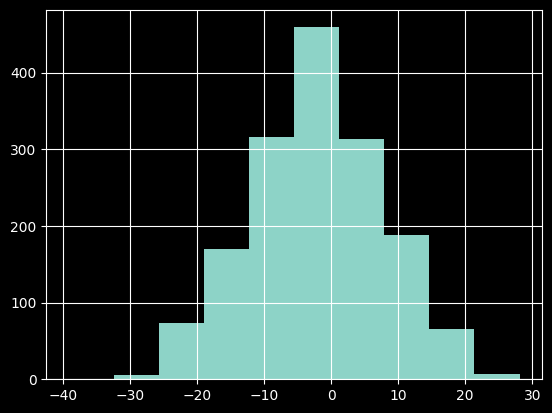

In [79]:
df_2022.units.hist()

in 2022, 40% of teams were making money against the spread

In [82]:
sum(df_2022.units > 0) / len(df_2022)

0.40175219023779724

57% had a winning record

In [86]:
sum(df_2022.win_pct > .5) / len(df_2022)

0.5694618272841051

overall win pct 51.2%

In [88]:
df_2022['W.1'].sum() / (df_2022['W.1'].sum() + df_2022['L.1'].sum())

np.float64(0.5116220331522013)

I found results from 2023-24 here: https://vegasfootballproxy.com/wp-content/uploads/2024/10/SuperContest-Standings-Week-18-2024.pdf

In [91]:
with open("../content/data/2024-supercontest.txt", "r") as f:
    data3 = f.read()

In [92]:
data3

"WEEK 18\nCONTESTANT W L T POINTS W L T POINTS\nWALKAMIN 3 2 0 3 60 29 1 60.5\nEXCELLENTO 4 1 0 4 59 29 2 60\nFIVE KINGS 4 1 0 4 57 29 4 59\nTA2 RG 3 2 0 3 58 30 2 59\nCOMMON CENTS 2 3 0 2 58 30 2 59\nLOCA LOSERS 2 3 0 2 57 29 4 59\nKENOCOP 2 3 0 2 58 30 2 59\nMEYER LANDSCAQPING 1 4 0 1 58 30 2 59\nCBPB 3 2 0 3 58 31 1 58.5\nLITTLE J 3 2 0 3 57 30 3 58.5\nTONY FROM NAPLES 3 2 0 3 57 31 2 58\nCOWPHINS13 2 3 0 2 56 30 4 58\nVISORS 1 4 0 1 57 31 2 58\nWEEZYBACK 4 1 0 4 56 31 3 57.5\nCOIN FLIP 3 2 0 3 56 31 3 57.5\nDEADWOOD TAVERN 1 5 0 0 5 56 32 2 57\nDR.M 2 3 0 2 56 32 2 57\nTA2 TWO 2 3 0 2 55 31 4 57\nWINNINGANGLE 5 0 0 5 55 32 3 56.5\nLOCO17 4 1 0 4 54 31 5 56.5\nMAYBE TOMORROW 4 4 1 0 4 55 32 3 56.5\nMM2024 4 1 0 4 54 32 4 56\nSEATTLE STEAMFITTER 3 2 0 3 55 33 2 56\nISNT THAT WONDERFUL 3 2 0 3 56 34 0 56\nBUY THE DIP 3 2 0 3 55 33 2 56\nINTL PING PONG 3 2 0 3 55 33 2 56\nFINMARK FOUR 3 2 0 3 54 32 4 56\nRAIDERNATION 2 3 2 0 3 54 32 4 56\nHAWK TUA MAHOMIES 2 3 0 2 54 32 4 56\nMIKE WINS

In [94]:
lines3=data3.split("\n")

In [102]:
matcher3 = r"^(.+?)\W(\d+)\W(\d+)\W(\d+)\W([\d\.]+)\W(\d+)\W(\d+)\W(\d+)\W([\d\.]+)$"

In [99]:
re.split(matcher3, lines3[2])

['', 'WALKAMIN 3', '2', '0', '3', '60', '29', '1', '60', '5', '']

In [108]:
re.split(matcher3, lines3[100])

['', 'PIPERS PIT 1', '2', '3', '0', '2', '50', '35', '5', '52.5', '']

In [106]:
clean3 = []

for line in lines3:
    line_split = re.split(matcher3, line)[1:-1]
    if len(line_split) > 0:
        clean3.append(line_split)

In [109]:
clean3[100]

['INDY BOYS', '2', '3', '0', '2', '51', '36', '3', '52.5']

In [111]:
numerics = ["week_win", "week_loss", "week_tie", "week_pts", "wins", "losses", "ties", "points"]

cols3 = ["team_name"] + numerics

stupor_2024 = pd.DataFrame(clean3, columns=cols3)
stupor_2024[numerics] = stupor_2024[numerics].apply(pd.to_numeric)
stupor_2024['units'] = stupor_2024.wins - (1.1 * stupor_2024.losses)
stupor_2024['win_pct'] = stupor_2024.wins / (stupor_2024.wins + stupor_2024.losses)

# should_be_numeric = ["wins", "losses", "ties", "cancels", "points"]

# cols = ["rank", "team_name"] + should_be_numeric

# stupor_contest = pd.DataFrame(clean, columns=cols)
# stupor_contest[should_be_numeric] = stupor_contest[should_be_numeric].apply(pd.to_numeric)
# stupor_contest['units'] = stupor_contest.wins - (1.1 * stupor_contest.losses)
# stupor_contest['win_pct'] = stupor_contest.wins / (stupor_contest.wins + stupor_contest.losses)
# stupor_contest['n_games'] = stupor_contest.wins + stupor_contest.losses # ignoring ties, which I'll not be simulating

# stupor_contest = stupor_contest.dropna()

In [112]:
stupor_2024.win_pct.describe()

count    1114.000000
mean        0.504975
std         0.060482
min         0.300000
25%         0.460674
50%         0.505747
75%         0.545455
max         0.674157
Name: win_pct, dtype: float64

In [113]:
stupor_2024.units.describe()

count    1114.000000
mean       -3.354758
std        10.946103
min       -34.900000
25%       -10.775000
50%        -3.300000
75%         4.000000
max        28.100000
Name: units, dtype: float64

in 2024, 63% of entrants lost money vs the vig

In [116]:
1-sum(stupor_2024.units > 0) / len(stupor_2024)

0.63016157989228

52% of entrants had a winning record

In [121]:
sum(stupor_2024.win_pct > .5) / len(stupor_2024)

0.5215439856373429

In [119]:
stupor_2024.wins.sum() / (stupor_2024.wins.sum() + stupor_2024.losses.sum())

np.float64(0.5053558281572426)

# Ah crap, there was a better data source all along

looks like they have records for many, many seasons

https://fantasysupercontest.com/supercontest-standings-2021-week-18?year=2021&limit=all&trend=all&team_option=text&format=csv

csv version here (but it's only top 500):

https://fantasysupercontest.com/supercontest-standings-gold-2021-week-18?format=csv


actually, that's a different competition


hopefully I can haxxor it

year=2021&limit=all&trend=all&team_option=text

yes, yes I can

https://fantasysupercontest.com/supercontest-standings-2021-week-18?year=2021&limit=all&trend=all&team_option=text&format=csv

the year in the URL needs to change as well

gonna start a new notebook

In [123]:
url_template = "https://fantasysupercontest.com/supercontest-standings-%(yyyy)s-week-18?year=%(yyyy)s&limit=all&trend=all&team_option=text&format=csv"

# note this will break when you go back far enough, there used to be 16 games



In [124]:
supper_contest = pd.read_csv(url_template % {'yyyy': 2021})

In [125]:
supper_contest

,rank,name,pick1,pick2,pick3,pick4,pick5,week_win,week_loss,week_push,season_win,season_lost,season_push,win%,points,order
0,1,LITOFSKY CLAN,KC,MIA,JAC,PIT,SF,4,1,0,61,27,2,69.3,62.0,1
1,1,.@SPORTSHANDICAPPER,DET,MIA,TB,BAL,SEA,4,1,0,62,28,0,68.9,62.0,2
2,3,XERRI 1,IND,WAS,NO,SEA,LAR,3,2,0,60,30,0,66.7,60.0,3
3,3,WALPERSPACH,MIN,NO,BAL,SEA,LV,4,1,0,59,29,2,67.0,60.0,4
4,5,VHL HANDICAPPING,KC,GB,TB,WAS,PIT,3,2,0,59,30,1,66.3,59.5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1814,1815,COCKROACH AND FRIEND,PHI,NE,NYJ,TB,TEN,1,4,0,31,58,1,34.8,31.5,1815
1815,1816,HOW YOU?,DAL,DEN,CHI,CAR,NO,3,2,0,31,59,0,34.4,31.0,1816
1816,1816,DA BAERS,KC,IND,ARI,LAR,LAC,0,5,0,31,59,0,34.4,31.0,1817
1817,1818,DR A,GB,TB,BAL,ARI,LAC,1,4,0,30,49,1,38.0,30.5,1818


In [126]:
supper_contest['win%'].describe()

count    1819.000000
mean       51.412314
std         5.412610
min        30.000000
25%        47.800000
50%        51.700000
75%        55.100000
max        69.300000
Name: win%, dtype: float64